<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html ae.do.txt  -->
<!-- dom:TITLE: Week 48: Autoencoders -->

# Week 48: Autoencoders
**Morten Hjorth-Jensen**, Department of Physics and Center for Computing in Science Education, University of Oslo, Norway

Date: **Nov 24, 2025**

Copyright 1999-2025, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license

## Back to Autoencoders: Linear Autoencoders

In [ ]:
%matplotlib inline

import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn >=0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow >= 2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)


np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

codings = encoder.predict(X_train)
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## More advanced features, stacked AEs

In [ ]:
# You can select the so-called fashion data as well, here we just use the MNIST standard set
#(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

We can now train all layers at once by building a stacked AE with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

This function processes a few test images through the autoencoder and
displays the original images and their reconstructions.

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

Then visualize

In [ ]:
np.random.seed(42)
from sklearn.manifold import TSNE
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

And visualize in a nicer way

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Using Convolutional Layers Instead of Dense Layers

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

In [ ]:
conv_encoder.summary()
conv_decoder.summary()

In [ ]:
show_reconstructions(conv_ae)
plt.show()

## Recurrent Autoencoders

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

## Stacked denoising Autoencoder with Gaussian noise

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

And using dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

## PyTorch example
We will continue with the MNIST database, which has $60000$ training examples and a test set of 10000 handwritten numbers. The images have
only one color channel and have a size of $28\times 28$ pixels.
We start by uploading the data set.

In [1]:
# import the Torch packages
# transforms are used to preprocess the images, e.g. crop, rotate, normalize, etc
import torch
from torchvision import datasets,transforms

# specify the data path in which you would like to store the downloaded files
# ToTensor() here is used to convert data type to tensor

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
print(train_dataset)
batchSize=128

#only after packed in DataLoader, can we feed the data into the neural network iteratively
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: ToTensor()


We visualize the images here using the $imshow$ function  function and the $make\_grid$ function from PyTorch to arrange and display them.

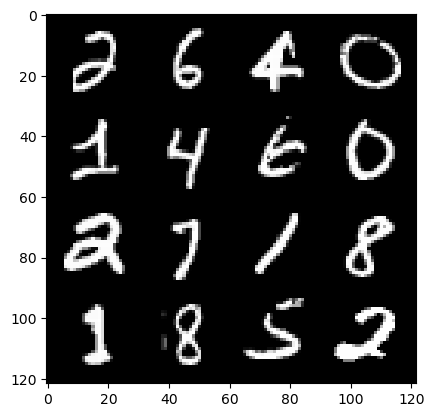

In [2]:
# package we used to manipulate matrix
import numpy as np
# package we used for image processing
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load the first 16 training samples from next iteration
# [:16,:,:,:] for the 4 dimension of examples, first dimension take first 16, other dimension take all data
# arrange the image in grid
examples, _ = next(iter(train_loader))
example_show=make_grid(examples[:16,:,:,:], 4)

# then display them
imshow(example_show)

Our autoencoder consists of two parts, see also the TensorFlow example
above. The encoder and decoder parts are represented by two fully
connected feed forward neural networks where we use the standard
Sigmoid function.  In the encoder part we reduce the dimensionality of
the image from $28\times 28=784$ pixels to first $16\times 16=256$
pixels and then to 128 pixels. The 128 pixel representation is then
used to define the representation of the input and the input to the
decoder part.  The latter attempts to reconstruct the images.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)


# Building the encoder
class Autoencoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2):
        super(Autoencoder, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        # decoder part
        self.fc3 = nn.Linear(h_dim2, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def decoder(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# When initializing, it will run __init__() function as above
model = Autoencoder(num_input, num_hidden_1, num_hidden_2)

We define here the cost/loss function and the optimizer we employ (Adam here).

In [4]:
# define loss function and parameters
optimizer = optim.Adam(model.parameters())
epoch = 100
# MSE loss will calculate Mean Squared Error between the inputs 
loss_function = nn.MSELoss()

print('====Training start====')
for i in range(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # prepare input data
        inputs = torch.reshape(data,(-1, 784)) # -1 can be any value.
        # set gradient to zero
        optimizer.zero_grad()
        # feed inputs into model
        recon_x = model(inputs)
        # calculating loss 
        loss = loss_function(recon_x, inputs)
        # calculate gradient of each parameter
        loss.backward()
        train_loss += loss.item()
        # update the weight based on the gradient calculated
        optimizer.step()
    if i%10==0:    
        print('====> Epoch: {} Average loss: {:.9f}'.format(i, train_loss ))
print('====Training finish====')

====Training start====
====> Epoch: 0 Average loss: 30.579419225
====> Epoch: 10 Average loss: 5.677109637
====> Epoch: 20 Average loss: 3.375376532
====> Epoch: 30 Average loss: 2.541718153
====> Epoch: 40 Average loss: 2.118307935
====> Epoch: 50 Average loss: 1.866089026
====> Epoch: 60 Average loss: 1.685287650
====> Epoch: 70 Average loss: 1.547592661
====> Epoch: 80 Average loss: 1.436785246
====> Epoch: 90 Average loss: 1.342284530
====Training finish====


As we have trained the network, we will now reconstruct various test samples to see if the model can generalize to data which
were not included in the training set.

In [ ]:
# load 16 images from testset
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
#inputs=inputs.cuda()
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=model(inputs)

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

After training the auto-encoder, we can now use the model to reconstruct some images.
In order to reconstruct different training images, the model
has learned to recognize how the image looks like and describe it in
the 128-dimensional  latent space. In other words, the visual information of
images is compressed and encoded in the 128-dimensional representations. As we
assume that samples from the same categories should be more visually
similar than those from different classes, the representations can
then be used for image recognition, i.e., handwritten digit images
recognition in our case.

One simple way to recognize images is to randomly select ten training
samples from each class and annotate them with the corresponding label.
Then given the
test data, we can predict which classes they belong to by finding the
most similar labelled training samples to them.

In [ ]:
# get 100 image-label pairs from training set
x_train, y_train = next(iter(train_loader))

# 10 classes, 10 samples per class, 100 in total
candidates = np.random.choice(batchSize, 10*10)

# randomly select 100 samples
x_train = x_train[candidates]
y_train = y_train[candidates]

# display the selected samples and print their labels

imshow(make_grid(x_train[:100,:,:,:],10))
print(y_train.reshape(10, 10))

# get 100 image-label pairs from test set
x_test, y_test = next(iter(train_loader))
candidates_test = np.random.choice(batchSize, 10*10)

x_test = x_test[candidates_test]
y_test = y_test[candidates_test]

# display the selected samples and print their labels
imshow(make_grid(x_test[:100,:,:,:],10))

print(y_test.reshape(10, 10))

In [ ]:
# compute the representations of training and test samples
#h_train=model.encoder(torch.reshape(x_train.cuda(),(-1,784)))
#h_test=model.encoder(torch.reshape(x_test.cuda(),(-1,784)))
h_train=model.encoder(torch.reshape(x_train,(-1,784)))
h_test=model.encoder(torch.reshape(x_test,(-1,784)))

# find the nearest training samples to each test instance, in terms of MSE
MSEs = np.mean(np.power(np.expand_dims(h_test.detach().cpu(), axis=1) - np.expand_dims(h_train.detach().cpu(), axis=0), 2), axis=2)
neighbours = MSEs.argmin(axis=1)
predicts = y_train[neighbours]

# print(np.stack([y_test, predicts], axis=1))
print('Recognition accuracy according to the learned representation is %.1f%%' % (100 * (y_test == predicts).numpy().astype(np.float32).mean()))

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_ds = datasets.MNIST(’.’, train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)


class Autoencoder(nn.Module):
def init(self, input_dim=28*28, hidden_dim=64, latent_dim=16):
super().init()
self.encoder = nn.Sequential(
nn.Flatten(),
nn.Linear(input_dim, hidden_dim),
nn.ReLU(),
nn.Linear(hidden_dim, latent_dim),
nn.ReLU()
)
self.decoder = nn.Sequential(
nn.Linear(latent_dim, hidden_dim),
nn.ReLU(),
nn.Linear(hidden_dim, input_dim),
nn.Sigmoid(),
nn.Unflatten(1, (1,28,28))
)
def forward(self, x):
z = self.encoder(x)
xhat = self.decoder(z)
return xhat

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



model.train()
for epoch in range(1, 11):
epoch_loss = 0.0
for xb, _ in train_loader:
optimizer.zero_grad()
xb = xb
xhat = model(xb)
loss = criterion(xhat, xb)
loss.backward()
optimizer.step()
epoch_loss += loss.item() * xb.size(0)
epoch_loss /= len(train_loader.dataset)
print(f”Epoch {epoch}, Loss: {epoch_loss:.6f}”)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(‘float32’) / 255.0
x_train = x_train[…, None]


input_shape = (28,28,1)
encoder_inputs = layers.Input(shape=input_shape)
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(64, activation=‘relu’)(x)
latent = layers.Dense(16, activation=‘relu’)(x)

x = layers.Dense(64, activation=‘relu’)(latent)
x = layers.Dense(28*28, activation=‘sigmoid’)(x)
outputs = layers.Reshape((28,28,1))(x)

autoencoder = models.Model(encoder_inputs, outputs)
autoencoder.compile(optimizer=‘adam’, loss=‘mse’)


autoencoder.fit(x_train, x_train, epochs=10, batch_size=128)